## Data Wrangling

This notebook is based on johnowhitaker's blog post found [here](https://datasciencecastnet.home.blog/2019/10/21/zindi-uberct-part-2-stepping-up/).

It will take you through some data wrangling with ```pandas``` and ```geopandas```; to create tabular data for an ```xgboost``` Machine Learning ```predicit```ion.

In [ ]:
#because we're on google colab
!pip install --upgrade pandas
!pip install --upgrade geopandas
!pip install --upgrade sklearn
!pip install --upgrade xgboost
#!pip install --upgrade seaborn

In [2]:
#load the modules that make the magic possible
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import itertools
import matplotlib.pyplot as plt
#import seaborn as sns
from pathlib import Path

In [13]:
from matplotlib import pyplot
from xgboost import XGBClassifier, plot_importance
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, auc, log_loss, accuracy_score, confusion_matrix, precision_score, mean_squared_error, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
from numpy import where, mean, sqrt, argmax, arange

In [ ]:
# mount google drive as a file system
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [5]:
#set path
path = Path('/content/gdrive/My Drive/Zindi_Accident')

In [6]:
import sys
sys.path.append('/content/gdrive/My Drive/Zindi_Accident')

# load a custom confusion_matrix tool for plotting 
# courtesy - leportella (https://github.com/leportella/federal-road-accidents)
from tools import plot_confusion_matrix

# Load data

Look at the ```train.csv``` and  ```road_segments.zip``` from [Zindi](https://zindi.africa/competitions/uber-movement-sanral-cape-town-challenge).

In [ ]:
# have a look
data = pd.read_csv(path/'data/train.csv', 
                   parse_dates = ['Occurrence Local Date Time'])
data.head()

,EventId,Occurrence Local Date Time,Reporting Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id
0,60558,2016-01-01 00:53:00,Cam,Stationary Vehicle,Vehicle On Shoulder,Closed,18.5408955032,-33.888275,S0B3CGQ
1,60559,2016-01-01 00:54:00,CAMERA,Accident,With A Fixed Object,Closed,18.9307563219,-34.140857,RYJYAPI
2,60560,2016-01-01 02:26:00,Law Enforcement,Accident,Multi Vehicle,Closed,18.5533575029,-33.959154,U3KP57C
3,60561,2016-01-01 02:56:00,CAMERA,Stationary Vehicle,Vehicle On Shoulder,Closed,18.6775561589,-33.895258,RY0TRQ8
4,60562,2016-01-01 03:40:00,CAMERA,Accident,Multi Vehicle,Closed,18.8371319682,-34.087051,8LOVJZ3


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53845 entries, 0 to 53844
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   EventId                     53845 non-null  int64         
 1   Occurrence Local Date Time  53845 non-null  datetime64[ns]
 2   Reporting Agency            52226 non-null  object        
 3   Cause                       53845 non-null  object        
 4   Subcause                    53845 non-null  object        
 5   Status                      53845 non-null  object        
 6   longitude                   53845 non-null  object        
 7   latitude                    53845 non-null  float64       
 8   road_segment_id             53845 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 3.7+ MB


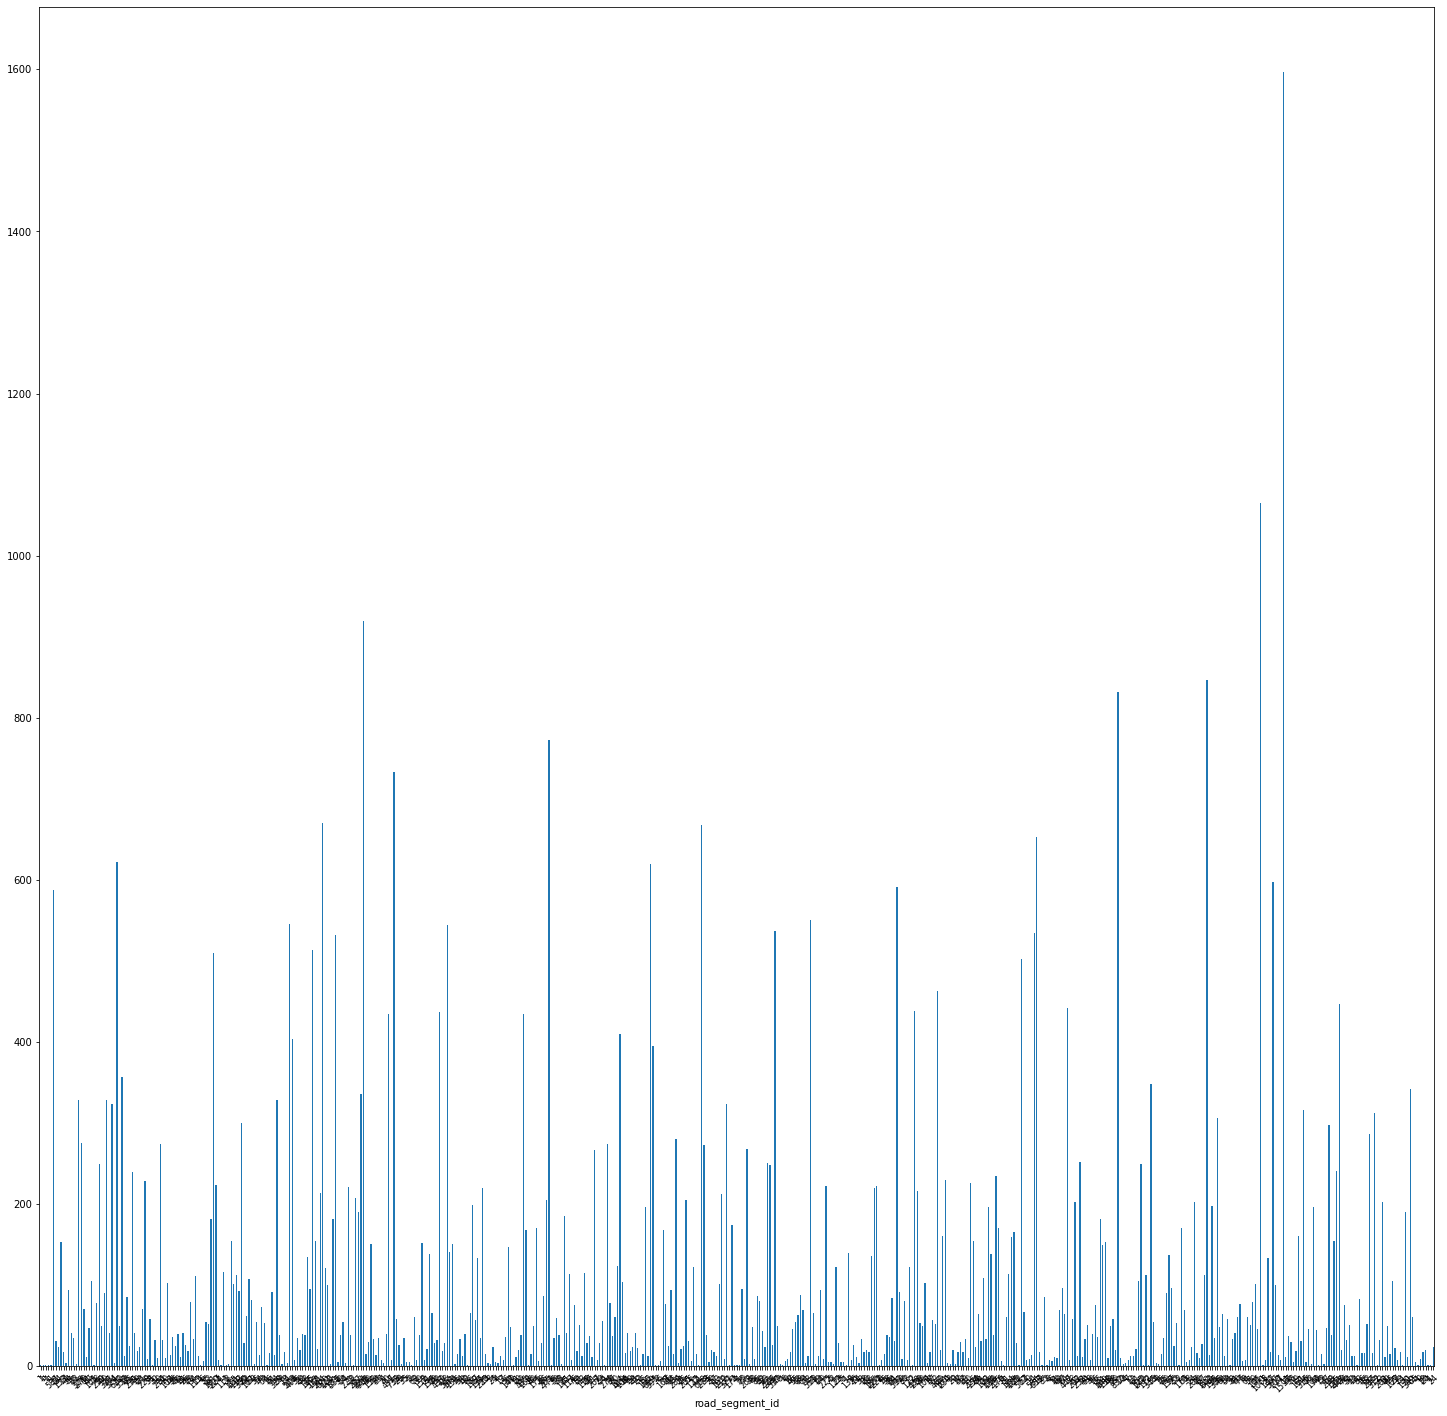

In [ ]:
# graph some columns
fig, ax = plt.subplots(figsize=(25,25)) 

rd_seg = data.groupby('road_segment_id').size()
rd_seg.plot(kind = 'bar')
ax.set_xticklabels(rd_seg, fontsize=8, rotation=45)

plt.show()

### As expected; some roads are more dangerous than others

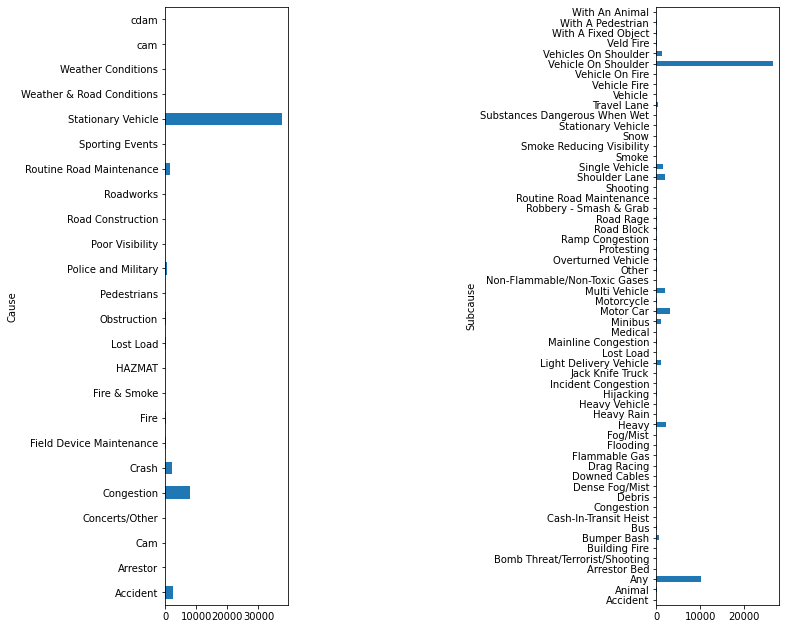

In [ ]:
# graph some more columns
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,11)) 

cause = data.groupby('Cause').size()
ax1 = cause.plot(ax=ax1, kind = 'barh')

Subcause = data.groupby('Subcause').size()
ax2 = Subcause.plot(ax=ax2, kind = 'barh')

fig.subplots_adjust(hspace=.5, wspace=3)

plt.show()

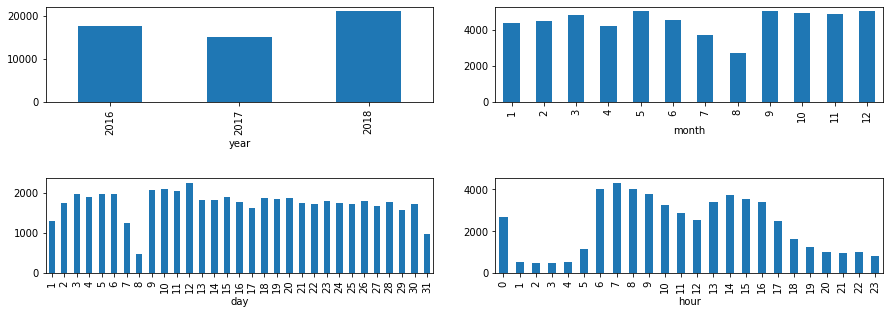

In [ ]:
# graph some more coulmns
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13,5))

data['year'] = data['Occurrence Local Date Time'].dt.year
year = data.groupby('year').size()
ax1 = year.plot(ax=ax1, kind = 'bar')
#ax[0, 0].set_title('Year')

data['month'] = data['Occurrence Local Date Time'].dt.month
month = data.groupby('month').size()
ax2 = month.plot(ax=ax2, kind = 'bar')

data['day'] = data['Occurrence Local Date Time'].dt.day
day = data.groupby('day').size()
ax3 = day.plot(ax=ax3,kind='bar')

data['hour'] = data['Occurrence Local Date Time'].dt.hour
hour = data.groupby('hour').size()
ax4 = hour.plot(ax=ax4, kind = 'bar')

data.drop('year', axis=1, inplace=True)
data.drop('month', axis=1, inplace=True)
data.drop('day', axis=1, inplace=True)
data.drop('hour', axis=1, inplace=True)

fig.tight_layout(pad=3.0)
plt.show()

### I want to plot this so; convert to geopandas

In [ ]:
data["longitude"] = pd.to_numeric(data["longitude"])
data["latitude"] = pd.to_numeric(data["latitude"])

ValueError: ignored

### Why did this happen? Somethings wrong with this data.

In [ ]:
#look at the index where this happened
print(data.loc[16693])

EventId                                     88632
Occurrence Local Date Time    2016-09-12 04:45:00
Reporting Agency                              NaN
Cause                                         Cam
Subcause                                 Accident
Status                             Single Vehicle
longitude                                  Closed
latitude                                  18.5642
road_segment_id                    -33.9622761744
Name: 16693, dtype: object


#### We see that the longitude and latitude are in the wrong columns. This is  likely to have happened more than once.

In [ ]:
data.rename(columns={'Reporting Agency': 'Reporting_Agency'}, inplace=True)

In [ ]:
def transform_row(r):
    '''
    Define a function to move cells along the same row when 'Closed' appears in ['longitude']
    '''
    if r.longitude == 'Closed':
        r.Reporting_Agency = r.Cause
        r.Cause = r.Subcause
        r.Subcause = r.Status
        r.Status = r.longitude
        r.longitude = r.latitude
        r.latitude = r.road_segment_id
        r.road_segment_id = np.nan
    return r

In [ ]:
data = data.apply(transform_row, axis=1)

In [ ]:
data.isna().sum()

EventId                          0
Occurrence Local Date Time       0
Reporting_Agency              1614
Cause                            0
Subcause                         0
Status                           0
longitude                        0
latitude                         0
road_segment_id                  5
dtype: int64

### It happended 5 times; but its better than deleting 1614 rows.

In [ ]:
# we don't need the Reporting Agency so leave that
data.dropna(subset=['road_segment_id'],inplace=True)

##### Lets try again

In [ ]:
data["longitude"] = pd.to_numeric(data["longitude"])
data["latitude"] = pd.to_numeric(data["latitude"])

In [ ]:
geodata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
geodata.head()

,EventId,Occurrence Local Date Time,Reporting_Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id,geometry
0,60558,2016-01-01 00:53:00,Cam,Stationary Vehicle,Vehicle On Shoulder,Closed,18.540896,-33.888275,S0B3CGQ,POINT (18.54090 -33.88827)
1,60559,2016-01-01 00:54:00,CAMERA,Accident,With A Fixed Object,Closed,18.930756,-34.140857,RYJYAPI,POINT (18.93076 -34.14086)
2,60560,2016-01-01 02:26:00,Law Enforcement,Accident,Multi Vehicle,Closed,18.553358,-33.959154,U3KP57C,POINT (18.55336 -33.95915)
3,60561,2016-01-01 02:56:00,CAMERA,Stationary Vehicle,Vehicle On Shoulder,Closed,18.677556,-33.895258,RY0TRQ8,POINT (18.67756 -33.89526)
4,60562,2016-01-01 03:40:00,CAMERA,Accident,Multi Vehicle,Closed,18.837132,-34.087051,8LOVJZ3,POINT (18.83713 -34.08705)


In [ ]:
#load the road_segments
road_segments = gpd.read_file(path/'data/road_segments.shp')

In [ ]:
road_segments.head()

,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,segment_id,geometry
0,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,D1U6OOF,"LINESTRING (18.65262 -33.97724, 18.65264 -33.9..."
1,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,NG4X2MD,"LINESTRING (18.65347 -33.97309, 18.65347 -33.9..."
2,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,792705Z,"LINESTRING (18.65431 -33.96894, 18.65432 -33.9..."
3,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,IK67XHB,"LINESTRING (18.65515 -33.96480, 18.65517 -33.9..."
4,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,OWCF2MH,"LINESTRING (18.65600 -33.96065, 18.65602 -33.9..."


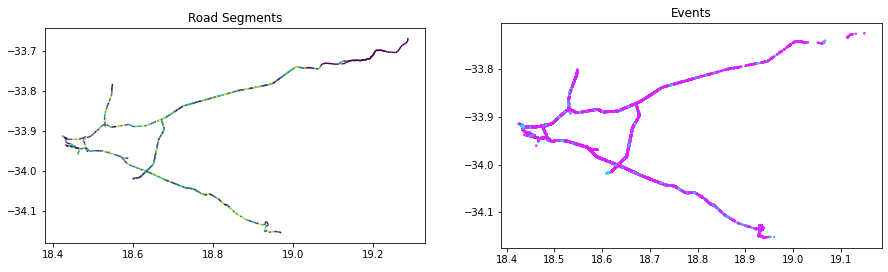

In [ ]:
# plot
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15)) 

ax1 = road_segments.plot(ax=ax1, column='segment_id', cmap='viridis')
ax1.set_title('Road Segments')

ax2 = geodata.plot(ax=ax2, marker=#'.', markersize = 8, column='Cause', cmap='cool')
ax2.set_title('Events')
plt.show()

#### Add a new column that represents the curvature of the road ```geometry```

In [ ]:
# harvest the mean locations of the road segments - as the competition is defined as "per 500-meter segment"
locations = data.groupby('road_segment_id').mean()[['longitude', 'latitude']]
locations.head(2)

,longitude,latitude
road_segment_id,,
03RHJ3G,18.460052,-33.943181
044ZYVD,18.555037,-33.890148


### Now we format, split the data into ```train``` and ```test``` sets and merge.


> NOTE: To overcome any ```out-of-memory``` challenges because of large file size, and because I'm on a shoestring budget but want to learn, I'm training on a years data and testing on three months.

In [ ]:
# Train on 2017
train = data.loc[data['Occurrence Local Date Time'] < '2018-01-01']
train = train.loc[train['Occurrence Local Date Time'] >= '2017-01-01']

# Test locally on the last part of 2018
local_test = data.loc[data['Occurrence Local Date Time'] < '2019-01-01']
local_test = local_test.loc[local_test['Occurrence Local Date Time'] >= '2018-09-01']

In [ ]:
# Create a dataframe with a column for each segment_id (sid)
# Each row represents an hour.

sids = data['road_segment_id'].unique()

dts = pd.date_range('2017-01-01',
                    '2018-01-01',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = train.loc[train['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
tr.head()

,datetime,S0B3CGQ,RYJYAPI,U3KP57C,RY0TRQ8,8LOVJZ3,X4UA382,0QR8FDW,DZABHQW,EKZN1VM,H9XYX9Q,03RHJ3G,FTX7LB8,Q03FQ74,5AC6YRF,1RWEBRU,DCB3LQM,HN83F3L,SPPGKO2,C1ERJ22,AJRKP0C,UUZT4OE,WAC029P,JT4HGZ2,8Z5P9T1,UAXX1ZE,74A6FL0,2M1UBKJ,E5D3KEB,NQSL7FX,S200A1J,ETFFDX5,R6JUSZT,EDXK0HP,N5NO82G,5DHNI4S,VUYACXV,VMCY8BI,927BHUF,3MW0MN9,...,J8FAZRB,P66KAPS,CJJI1XY,K3N8ADC,SG89YSS,XYFQJ1Q,QTT8QNT,LC8FONX,WJXP54Z,GVQD9D6,64QSPWU,LRCHHQJ,Q2HCM1O,F055OA5,SY568EU,QBSA1OR,8YJIRQ2,KVOVDD8,H983665,7T2W8WU,4NSOFJG,4UAL23D,956JU5F,B8NRA4K,PH8DIYU,F47NAGJ,1NG8I9K,ZP9STNM,D3349RH,E4L0I98,YVR8GT6,ZAVM3PJ,DS4NLQE,HR19LL7,1451FOG,2ON8NSO,NFUEAN5,4T821GV,J6A19TW,43RCYZH
0,2017-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Reshape this as in sample submission
# add some extra columns that may be useful
train = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
train.head()

,datetime x segment_id,datetime,segment_id,y
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0
1,2017-01-01 00:00:00 x RYJYAPI,2017-01-01 00:00:00,RYJYAPI,0
2,2017-01-01 00:00:00 x U3KP57C,2017-01-01 00:00:00,U3KP57C,0
3,2017-01-01 00:00:00 x RY0TRQ8,2017-01-01 00:00:00,RY0TRQ8,0
4,2017-01-01 00:00:00 x 8LOVJZ3,2017-01-01 00:00:00,8LOVJZ3,0


In [ ]:
# Same for local test
dts = pd.date_range('2018-09-01','2018-12-31',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = local_test.loc[local_test['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
    
test = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
test.head()

,datetime x segment_id,datetime,segment_id,y
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0
1,2018-09-01 00:00:00 x RYJYAPI,2018-09-01 00:00:00,RYJYAPI,0
2,2018-09-01 00:00:00 x U3KP57C,2018-09-01 00:00:00,U3KP57C,0
3,2018-09-01 00:00:00 x RY0TRQ8,2018-09-01 00:00:00,RY0TRQ8,0
4,2018-09-01 00:00:00 x 8LOVJZ3,2018-09-01 00:00:00,8LOVJZ3,0


In [ ]:
#add some colums
train['datetime'] = pd.to_datetime(train['datetime'])
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.weekday
train['hour'] = train['datetime'].dt.hour

In [ ]:
train.head()

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01,S0B3CGQ,0,2017,1,6,0
1,2017-01-01 00:00:00 x RYJYAPI,2017-01-01,RYJYAPI,0,2017,1,6,0
2,2017-01-01 00:00:00 x U3KP57C,2017-01-01,U3KP57C,0,2017,1,6,0
3,2017-01-01 00:00:00 x RY0TRQ8,2017-01-01,RY0TRQ8,0,2017,1,6,0
4,2017-01-01 00:00:00 x 8LOVJZ3,2017-01-01,8LOVJZ3,0,2017,1,6,0


In [ ]:
#do the same for the test
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.weekday
test['hour'] = test['datetime'].dt.hour

In [ ]:
# add some more data - roads and location

#locations
train = pd.merge(train, locations, left_on='segment_id', right_on='road_segment_id')
# road data
train = pd.merge(train, road_segments[['segment_id','WIDTH','LANES']], on='segment_id', how='left')
train.head(3)

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,WIDTH,LANES
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0,2017,1,6,0,18.541422,-33.888613,0.0,0
1,2017-01-01 01:00:00 x S0B3CGQ,2017-01-01 01:00:00,S0B3CGQ,0,2017,1,6,1,18.541422,-33.888613,0.0,0
2,2017-01-01 02:00:00 x S0B3CGQ,2017-01-01 02:00:00,S0B3CGQ,0,2017,1,6,2,18.541422,-33.888613,0.0,0


In [ ]:
# Same for the test
#locations
test = pd.merge(test, locations, left_on='segment_id', right_on='road_segment_id')
# road data
test = pd.merge(test, road_segments[['segment_id','WIDTH','LANES']], on='segment_id', how='left')
test.head(3)


,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,WIDTH,LANES
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0,2018,9,5,0,18.541422,-33.888613,0.0,0
1,2018-09-01 01:00:00 x S0B3CGQ,2018-09-01 01:00:00,S0B3CGQ,0,2018,9,5,1,18.541422,-33.888613,0.0,0
2,2018-09-01 02:00:00 x S0B3CGQ,2018-09-01 02:00:00,S0B3CGQ,0,2018,9,5,2,18.541422,-33.888613,0.0,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#make sure the data is numeric
train["month"] = pd.to_numeric(train["month"])
train["day"] = pd.to_numeric(train["day"])
train["hour"] = pd.to_numeric(train["hour"])
train["WIDTH"] = pd.to_numeric(train["WIDTH"])
train["LANES"] = pd.to_numeric(train["LANES"])

### Save both ```train``` and ```test``` to load in the next ```notebook``` and add data too.

In [ ]:
#save it
train.to_csv(path/'data/train_basic.csv', index=False)
test.to_csv(path/'data/test_basic.csv', index=False)

#for visulaization
local_test.to_csv(path/'data/local_test_vis.csv', index=False)

In [ ]:
#clean up
data, local_test = 0, 0

In [10]:
# define a list of column names to be used for training
x_cols = ['month', 'day', 'hour', 'longitude', 'latitude', 'WIDTH', 'LANES']

In [11]:
X, y = train[x_cols], train['y']

#### ```train_test_split``` 75/25.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Before we go any further: we need to do some more wrangling because our data is highly imbalanced.

Class 0: 3563836
Class 1: 10652


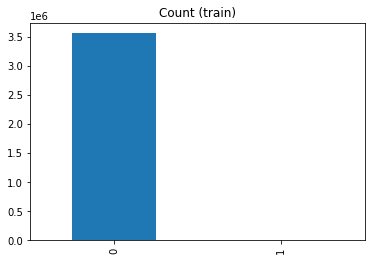

In [15]:
# count examples in each class
train_count = y_train.value_counts()
print('Class 0:', train_count[0])
print('Class 1:', train_count[1])
train_count.plot(kind='bar', title='Count (train)')
plt.show()

#### Why does this matter?

> Lets run a quick example with the data 'as-is'.



In [18]:
model = XGBClassifier(objective ='binary:logistic')              # set model
model.fit(X_train, y_train)                                      # what do you want to train with?
preds = model.predict(X_train)                                   # what do you want to predict?
print('')
print(preds)                                                     # print the predictions
# Get scores                                                     # lets look at some accuracy measures
accuracy = accuracy_score(y_train, preds)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
rmse = mean_squared_error(y_train, preds)
print("RMSE: %f" % (rmse))
f1 = f1_score(y_train, preds)
print('f1-score: %.2f%%' % f1)


[0 0 0 ... 0 0 0]
Accuracy: 99.70%
RMSE: 0.002977
f1-score: 0.00%


#### Our ```accuracy``` is amazing but our ```f1-score``` is ```0```.

In [19]:
# Show predicted classes
print(np.unique(preds, return_counts=True))

(array([0, 1]), array([3574454,      34]))


Confusion matrix, without normalization
[[3563825      11]
 [  10629      23]]


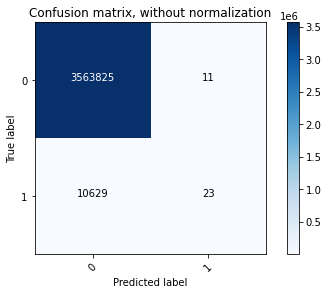

In [20]:

cnf_matrix = confusion_matrix(y_train, preds)
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')

#### We're ```predict```ing ```0```'s and ```1```'s equally and not enough of iether. We need to add some kind of ```weight``` so that the algorithm knows to add more emphasis to one class. Luckily we can estimate a ```scale_pos_weight```...

#### Per the documentation ```scale_pos_weight = count(negative examples)/count(Positive examples)``` but from this [thread](https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets) ```scale_pos_weight = sqrt(count(negative examples)/count(Positive examples))``` might prove a better estimate.

In [21]:
# estimate scale_pos_weight value
estimate = sqrt(train_count[0] / train_count[1])
print('Estimate (class imbalance): %.3f' % estimate)

Estimate (class imbalance): 18.291


In [24]:
# Create the model - we start with basic parameters which we'll tune as we go along; for now set scale_pos_weight
model = XGBClassifier(objective='binary:logistic', 
                      scale_pos_weight=18.274)

#### ... or perform a ```grid search``` - which I could not get to work.

In [23]:
model = XGBClassifier(objective='binary:logistic')

# define grid
param_grid = {                           
    'scale_pos_weight': [100, 300, 500] # these values can change
    }

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=cv, scoring='f1',verbose=3)

# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] scale_pos_weight=100 ............................................


KeyboardInterrupt: ignored

#### Lets continue with the estimated ```scale_pos_weight```

In [26]:
%%time
#fit
model.fit(X_train, y_train)

CPU times: user 10min 45s, sys: 822 ms, total: 10min 45s
Wall time: 5min 34s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=18.274, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### ```most_important``` features

In [27]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
sorted_idx


array([3, 4, 2, 0, 1, 5, 6])

In [28]:
for index in sorted_idx:
    print([train.columns[index], model.feature_importances_[index]]) 

['y', 0.33944213]
['year', 0.23138867]
['segment_id', 0.19666845]
['datetime x segment_id', 0.11237471]
['datetime', 0.06834111]
['month', 0.051784962]
['day', 0.0]


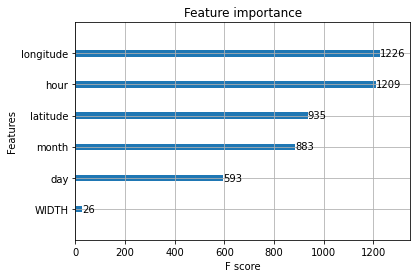

In [29]:
plot_importance(model, max_num_features = 7)
pyplot.show()

#### ```hour``` of the day!

## Optimal Threshold for ROC Curve

> A useful tool when predicting the probability of a binary outcome is the *Receiver Operating Characteristic* curve, or ROC curve.

> It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. In other words, it plots the false alarm rate versus the hit rate - There are many awesome resources online for detailed explanations. [Machine Learning Mastery](https://machinelearningmastery.com/) helped me.





In [62]:
#lets predict *PROBABILITIES*  on the training-set
y_pred_train = model.predict_proba(X_train)

In [63]:
# keep probabilities for the positive outcome only
y_pred_train = y_pred_train[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)

#lets predict *PROBABILITIES*  on the training-set
y_pred_test = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_pred_test = y_pred_test[:, 1]
# calculate roc curves
fpr_t, tpr_t, thresholds_t = roc_curve(y_test, y_pred_test)

In [65]:
# calculate the g-mean for each threshold
#the train
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best ROC Training Threshold = %f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#the test
gmeans_t = sqrt(tpr_t * (1-fpr_t))
# locate the index of the largest g-mean
ix_t = argmax(gmeans_t)
print('Best ROC Training Threshold = %f, G-Mean=%.3f' % (thresholds_t[ix_t], gmeans_t[ix_t]))

Best ROC Training Threshold = 0.065169, G-Mean=0.843
Best ROC Training Threshold = 0.046988, G-Mean=0.810


#### The score johnowhitaker recommends

In [66]:
print('Training log_loss:', log_loss(y_train, y_pred_train))
print('')
print('Training log_loss:', log_loss(y_test, y_pred_test))

Training log_loss: 0.04834412478145234

Training log_loss: 0.04918006201198727


#### Plot ROC curves for both the ```training``` and ```test``` datasets

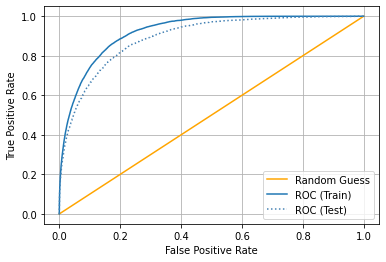

In [67]:
#plot
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange')#,lw=3)
plt.plot(fpr,tpr,label='ROC (Train)')#,lw=3)
plt.plot(fpr_t,tpr_t,'r:',label='ROC (Test)',color='steelblue')#,lw=3)
#pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Train')
#pyplot.scatter(fpr_test[ix_t], tpr_test[ix_t], marker='o', color='red', label='Best Test')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

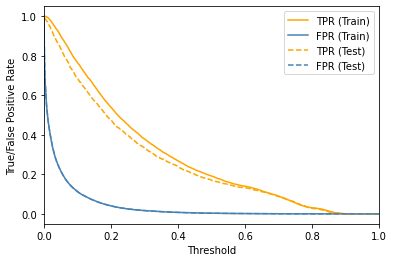

In [70]:
plt.plot(thresholds,tpr,'r-',label='TPR (Train)',color='orange')#,lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Train)',color='steelblue')#,lw=3)
plt.plot(thresholds_t,tpr_t,'--',label='TPR (Test)',color='orange')#,lw=3)
plt.plot(thresholds_t,fpr_t,'--',label='FPR (Test)',color='steelblue')#,lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive Rate')
plt.legend()
plt.show()

## Optimal Threshold for Precision-Recall Curve

> Precision: The fraction of the time we are correct when making a positive prediction (saying there is an accident)

> Recall: The fraction of accidents we predict. 

#### We can calculate a Precision-Recall Curve with probabilities but to genereate a meaningful ```f1-score```/measure (the challenge requirement) we need to predict a class - a ```0``` or a ```1```.


In [73]:
#for the training
# predict class values
yhat = model.predict(X_train)
lr_precision, lr_recall, thresh = precision_recall_curve(y_train, y_pred_train)
lr_f1, lr_auc = f1_score(y_train, yhat), auc(lr_recall, lr_precision)
# summarize scores
print(' Training Classification: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('')
#for the training
# predict class values
yhat_t = model.predict(X_test)
lr_precision_t, lr_recall_t, thresh_t = precision_recall_curve(y_test, y_pred_test)
lr_f1_t, lr_auc_t = f1_score(y_test, yhat_t), auc(lr_recall_t, lr_precision_t)
# summarize scores
print(' Test Classification: f1=%.3f auc=%.3f' % (lr_f1_t, lr_auc_t))

 Training Classification: f1=0.162 auc=0.083

 Test Classification: f1=0.146 auc=0.070


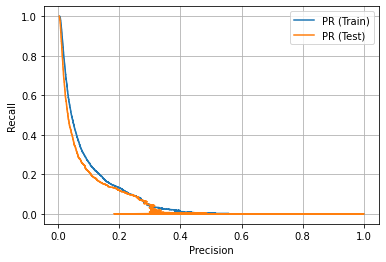

In [74]:
fig,ax = plt.subplots()
plt.plot(lr_precision,lr_recall,label='PR (Train)')#,lw=3)
plt.plot(lr_precision_t,lr_recall_t,label='PR (Test)')
#pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best Training')
#pyplot.scatter(recall_test[ix_t], precision_test[ix_t], marker='o', color='red', label='Best Test')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.show()

#### The scores show: the model that looked good according to the ```ROC Curve``` is in fact not so; when considering the ```precision and recall``` that focus on the positive class. The plot highlights that the model is just barely above the no skill line for most thresholds.

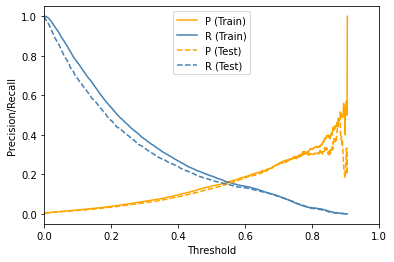

In [75]:
# threshold plot
plt.plot(thresh,lr_precision[:-1],'r-',label='P (Train)',color='orange')#,lw=3)
plt.plot(thresh,lr_recall[:-1],'r-',label='R (Train)',color='steelblue')#,lw=3)
plt.plot(thresh_t,lr_precision_t[:-1],'--',label='P (Test)',color='orange')
plt.plot(thresh_t,lr_recall_t[:-1],'--',label='R (Test)',color='steelblue')
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Threshold Tuning for F1-Score



> Our ```proba```bilities are ok. Now we need to apply a ```threshold``` to maximize an ```f1-score```. Why do we care about the ```f1-score```/measure: because it is the harmonic mean between ```precision``` and ```recall```. We can search for one.



In [41]:
# apply threshold to predictions to create labels
def to_labels(pos_preds, threshold):
  '''
  define a function to take the prediction and threshold as an argument and return an array of integers in {0, 1}
  '''
  return (pos_preds >= threshold).astype(int)

In [42]:
# define thresholds (start, stop, step)
threshold = np.arange(0, 1, 0.002)

In [43]:
# evaluate each threshold
scores = [f1_score(y_train, to_labels(y_pred_train, t)) for t in threshold]

In [44]:
# get best threshold
ix = argmax(scores)
print('Training Threshold = %.3f, F-Score = %.5f' % (threshold[ix], scores[ix]))

Training Threshold = 0.508, F-Score = 0.16283


#### The tuning confirms the Precision/Recall-Threshold ```plot``` above.

## Predicting

In [47]:
print('Predicting on the Training-set with a Threshold of = %.3f' % 0.508)
train['pred'] = (model.predict(train[x_cols]) > 0.508).astype(int)
print(' Accuracy:',accuracy_score(train['y'],train['pred']))
#rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (mean_squared_error(train['y'],train['pred'])))
print(' f1-score for the + class:',f1_score(train['y'],train['pred']))
print(' Precision for the + class:',precision_score(train['y'],train['pred']))
print(' Recall for the + class:',recall_score(train['y'],train['pred']))
#y_pred_train = model.predict(train[x_cols])
print(' AUC:',roc_auc_score(train['y'],train['pred']))
print(' Ave. Precision:',average_precision_score(train['y'],train['pred']))
train.head(3)

Predicting on the Training-set with a Threshold of = 0.508
 Accuracy: 0.9940706892847311
RMSE: 0.005929
 f1-score for the + class: 0.1580311652712809
 Precision for the + class: 0.13717477887549787
 Recall for the + class: 0.18636683063949402
 AUC: 0.5914281687308033
 Ave. Precision: 0.02799412774803429


,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,WIDTH,LANES,pred
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0,2017,1,6,0,18.541422,-33.888613,0.0,0,0
1,2017-01-01 01:00:00 x S0B3CGQ,2017-01-01 01:00:00,S0B3CGQ,0,2017,1,6,1,18.541422,-33.888613,0.0,0,0
2,2017-01-01 02:00:00 x S0B3CGQ,2017-01-01 02:00:00,S0B3CGQ,0,2017,1,6,2,18.541422,-33.888613,0.0,0,0


In [48]:
# Show predicted classes
print(np.unique(train['pred'], return_counts=True))

(array([0, 1]), array([4746651,   19333]))


Confusion matrix, without normalization
[[4735073   16681]
 [  11578    2652]]


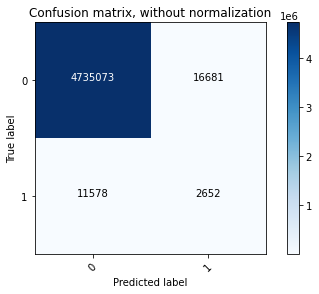

In [49]:
cnf_matrix = confusion_matrix(train['y'], train['pred'])
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')

In [50]:
print(len(train))
good = train.loc[train['pred'] == 1]
print(len(good))

4765984
19333


In [52]:
#have a look at the built-in report
print(classification_report(train['y'], train['pred']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4751754
           1       0.14      0.19      0.16     14230

    accuracy                           0.99   4765984
   macro avg       0.57      0.59      0.58   4765984
weighted avg       0.99      0.99      0.99   4765984



### Now our personal ```test```.

In [54]:
print('Predicting on the Test-set with a Threshold of = %.3f' % 0.508)
prediction['pred'] = (model.predict(prediction[x_cols]) > 0.508).astype(int)
print (' Accuracy:',accuracy_score(prediction['y'],prediction['pred']))
#rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (mean_squared_error(prediction['y'], prediction['pred'])))
print (' f1-score for the + class:',f1_score(prediction['y'],prediction['pred']))
print (' Precision for the + class:',precision_score(prediction['y'],prediction['pred']))
print (' Recall for the + class:',recall_score(prediction['y'],prediction['pred']))
#y_pred_test = model.predict(test[x_cols])
print (' AUC:',roc_auc_score(prediction['y'],prediction['pred']))
print (' Ave. Precision:',average_precision_score(prediction['y'],prediction['pred']))
prediction.head(3)

Predicting on the Test-set with a Threshold of = 0.508
 Accuracy: 0.9895350308798218
RMSE: 0.010465
 f1-score for the + class: 0.050522448042255134
 Precision for the + class: 0.05
 Recall for the + class: 0.051055929449988394
 AUC: 0.522868427484474
 Ave. Precision: 0.007727697758314951


,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,WIDTH,LANES,pred
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0,2018,9,5,0,18.541422,-33.888613,0.0,0,0
1,2018-09-01 01:00:00 x S0B3CGQ,2018-09-01 01:00:00,S0B3CGQ,0,2018,9,5,1,18.541422,-33.888613,0.0,0,0
2,2018-09-01 02:00:00 x S0B3CGQ,2018-09-01 02:00:00,S0B3CGQ,0,2018,9,5,2,18.541422,-33.888613,0.0,0,0


In [55]:
# Show predicted classes
print(np.unique(prediction['pred'], return_counts=True))

(array([0, 1]), array([1571520,    8800]))


Confusion matrix, without normalization
[[1563342    8360]
 [   8178     440]]


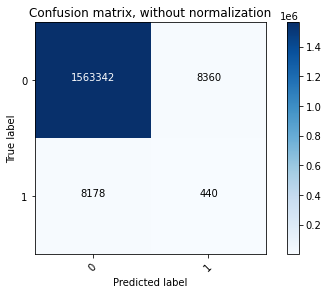

In [56]:
cnf_matrix = confusion_matrix(prediction['y'], prediction['pred'])
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')

In [57]:
#have a look at the built-in report
print(classification_report(prediction['y'], prediction['pred']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1571702
           1       0.05      0.05      0.05      8618

    accuracy                           0.99   1580320
   macro avg       0.52      0.52      0.52   1580320
weighted avg       0.99      0.99      0.99   1580320



### Save only the events to visualize

In [58]:
print(len(prediction))
good = prediction.loc[prediction['pred'] == 1]
print(len(good))

1580320
8800


In [59]:
good.head(2)

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,WIDTH,LANES,pred
1560,2018-11-05 00:00:00 x S0B3CGQ,2018-11-05,S0B3CGQ,0,2018,11,0,0,18.541422,-33.888613,0.0,0,1
1584,2018-11-06 00:00:00 x S0B3CGQ,2018-11-06,S0B3CGQ,0,2018,11,1,0,18.541422,-33.888613,0.0,0,1


In [ ]:
#save it
good[['segment_id', 'year', 'month', 'day', 'hour', 'latitude', 'longitude']].to_csv(path/'data/01_basicXGBoost.csv', 
                                                                                                 index=False)